In [1]:
"""
==============================================================================
DATA PREPARATION AND VISUALIZATION
==============================================================================

This cell performs the necessary data preprocessing steps for the Quantum Kernel
experiment. The workflow is as follows:

1.  **Imports**: Loads essential libraries for numerical computing (NumPy, SciPy),
    machine learning (Scikit-Learn), and quantum computing (PennyLane).

2.  **Data Generation**: Creates the "Two Moons" dataset. This is a classic
    synthetic dataset used to test non-linear classification, consisting of two
    interleaving half-circles.
    - Noise is added (0.10) to make the classification task realistic.

3.  **Train/Test Split**: Separates the data into training (70%) and testing (30%)
    sets. Stratify is used to ensure both classes are equally represented.

4.  **Feature Scaling (CRITICAL)**: Applies Standard Scaling (Z-score normalization)
    to the features.
    - Why? Quantum embedding circuits (like Pauli rotations) are sensitive to
      input ranges. Unscaled data can lead to periodicity issues (wrapping around
      the Bloch sphere multiple times), making the model hard to train.

5.  **Visualization**: Plots the training data to visually confirm the structure
    of the two classes before kernel mapping.
==============================================================================
"""

'\n==============================================================================\nDATA PREPARATION AND VISUALIZATION\n==============================================================================\n\nThis cell performs the necessary data preprocessing steps for the Quantum Kernel\nexperiment. The workflow is as follows:\n\n1.  **Imports**: Loads essential libraries for numerical computing (NumPy, SciPy),\n    machine learning (Scikit-Learn), and quantum computing (PennyLane).\n\n2.  **Data Generation**: Creates the "Two Moons" dataset. This is a classic\n    synthetic dataset used to test non-linear classification, consisting of two\n    interleaving half-circles.\n    - Noise is added (0.10) to make the classification task realistic.\n\n3.  **Train/Test Split**: Separates the data into training (70%) and testing (30%)\n    sets. Stratify is used to ensure both classes are equally represented.\n\n4.  **Feature Scaling (CRITICAL)**: Applies Standard Scaling (Z-score normalization)\n   

Train size: 210    Test size: 90


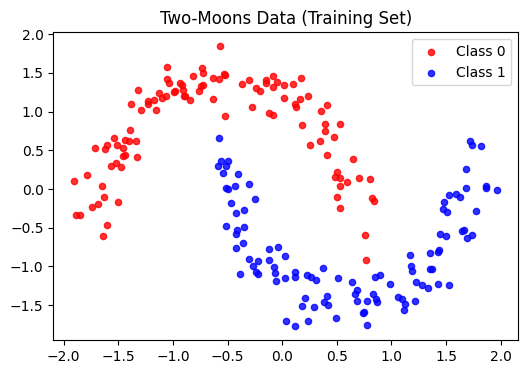

In [7]:
"""
==============================================================================
STEP 1: DATA PREPARATION
==============================================================================
We generate the 'Two Moons' dataset, a standard benchmark for non-linear 
classification. The data is split and standardized.
Standardization is CRITICAL for Quantum Machine Learning to ensure input features 
scale correctly to rotation angles (e.g., avoiding 0 to 2*pi wrapping issues).
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel
import pennylane as qml
from scipy.linalg import sqrtm

# Set seed for reproducibility
np.random.seed(422)

# 1. Generate Data
# Creating a synthetic dataset with non-linear separation
X_raw, y = make_moons(n_samples=300, noise=0.10, random_state=0)

# 2. Train/Test Split
# We stratify to ensure equal class distribution in both sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.30, random_state=0, stratify=y
)

# 3. Feature Scaling
# Standard Scaler (Z-score normalization) fits on training data only
scaler = StandardScaler().fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

print(f"Train size: {X_train.shape[0]}    Test size: {X_test.shape[0]}")

# 4. Visualization
# Plotting the training data to understand the geometry
plt.figure(figsize=(6, 4))
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='red', s=20, alpha=0.8, label="Class 0")
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='blue', s=20, alpha=0.8, label="Class 1")
plt.title("Two-Moons Data (Training Set)")
plt.legend()
plt.show()

In [ ]:
"""
==============================================================================
QUANTUM KERNEL DEFINITIONS & EMBEDDING CIRCUITS
==============================================================================

This cell defines the core components of the quantum machine learning model:
the feature maps (embeddings) and the kernel calculation logic.

1.  **Device Setup**: Initializes a 'default.qubit' simulator. The number of
    qubits matches the number of features in the dataset (2 qubits for 2 features).

2.  **Embedding E1 (Separable)**:
    - Encodes data using only single-qubit Rotation-X (RX) gates.
    - NO Entanglement. Each feature is processed independently.
    - Mathematically simple; often easy to simulate classically.

3.  **Embedding E2 (IQP - Instantaneous Quantum Polynomial)**:
    - A more complex embedding designed to be hard to simulate classically.
    - Uses Hadamard gates and entangling ZZ-interactions between qubits.
    - This creates 'Quantum Entanglement', potentially capturing complex
      correlations in the data that E1 cannot.

4.  **Kernel Calculation (The 'Overlap' or 'Fidelity' Test)**:
    - To compute the kernel value K(x, y) = |<phi(x)|phi(y)>|^2, we use a
      circuit trick:
      1. Apply embedding for x: U(x)|0>
      2. Apply the INVERSE (adjoint) embedding for y: U†(y)
      3. Measure the probability of returning to the all-zero state |0...0>.
    - If x and y are identical, U†(y) cancels U(x), yielding probability 1.0.
    - If x and y are orthogonal, the probability is 0.0.

5.  **Kernel Matrix Construction**:
    - Computes the pairwise similarity (Gram matrix) for the entire dataset
      using the overlap function defined above.
==============================================================================
"""

In [8]:
"""
==============================================================================
STEP 2: DEFINING QUANTUM KERNELS
==============================================================================
Here we define the quantum circuits that map classical data into Hilbert space.
We compare two strategies:
1. E1 (Separable): Simple rotations. No entanglement.
2. E2 (IQP): Complex structure with entanglement. Hard to simulate classically.

We also define the 'overlap_prob' function, which computes the kernel entry:
K(x, y) = |<phi(x)|phi(y)>|^2 using the 'compute-uncompute' method.
"""

n_features = X_train.shape[1]
n_qubits = n_features

# Initialize Quantum Device (Simulator)
# Note: 'default.qubit' runs on CPU.
dev = qml.device("default.qubit", wires=n_qubits)

# -- E1: Separable RX rotations (Trivial Kernel) --
# Maps features to qubit rotations independently.
def embedding_E1(features):
    for j, xj in enumerate(features):
        qml.RX(np.pi * xj, wires=j)

# -- E2: IQP embedding (Quantum Advantage Candidate) --
# Uses Hadamard gates and ZZ-interactions to create entanglement.
def embedding_E2(features):
    qml.IQPEmbedding(features, wires=range(n_features))

# Helper function to compute Fidelity (Overlap)
def overlap_prob(x, y, embed):
    """
    Computes the squared overlap |<phi(x)|phi(y)>|^2.
    Method: Apply U(x), then apply U_inverse(y), then measure probability of |0..0>.
    """
    @qml.qnode(dev)
    def circuit():
        embed(x)
        qml.adjoint(embed)(y) # Adjoint = Inverse operation
        return qml.probs(wires=range(n_qubits))
    
    # Return the probability of the all-zero state (index 0)
    return circuit()[0]

# Function to compute the full Gram Matrix
# This iterates over all pairs in the dataset. Complexity: O(N^2).
def quantum_kernel_matrix(X, embed):
    return qml.kernels.kernel_matrix(X, X, lambda v1, v2: overlap_prob(v1, v2, embed))

print("Quantum Kernels defined. Ready for calculation.")

Quantum Kernels defined. Ready for calculation.


In [ ]:
"""
==============================================================================
COMPUTATION OF GRAM MATRICES (KERNEL MATRICES)
==============================================================================

In this step, we compute the "Gram Matrix" for each kernel type.
A Gram Matrix is a square matrix (N x N) representing the pairwise similarity
between every data point in the training set.

1.  **Classical RBF (Baseline)**:
    - Uses Scikit-Learn's optimized `rbf_kernel`.
    - Extremely fast computation.
    - Serves as the standard geometry against which we compare the quantum kernels.

2.  **Quantum Kernels (E1 & E2)**:
    - We use the `quantum_kernel_matrix` function defined previously.
    - **Note on Performance**: This step is computationally intensive!
      For a dataset of size N, we must execute the quantum circuit N² times
      (once for every pair of points).
    - E1 (Simple): Computes similarity based on the separable embedding.
    - E2 (Complex): Computes similarity based on the entangled IQP embedding.

3.  **Result**:
    - We end up with three matrices of shape (N_train, N_train).
    - These matrices contain all the information the SVM needs to classify the data.
==============================================================================
"""

In [9]:
"""
==============================================================================
STEP 3: COMPUTING KERNEL MATRICES
==============================================================================
We calculate the Gram Matrices for the training set.
- K_classical: Calculated via Scikit-Learn (RBF Kernel).
- K_quantum_E1: Calculated via simulation (Separable).
- K_quantum_E2: Calculated via simulation (Entangled).

NOTE: The quantum calculations can take several minutes due to the O(N^2) 
circuit executions required on the CPU simulator.
"""

# 1. Classical RBF (Baseline Reference)
print("Computing Classical RBF Kernel...")
K_classical = rbf_kernel(X_train, gamma=1.0)

# 2. Quantum E1 (Simple/Separable)
print("Computing Quantum Kernel E1...")
K_quantum_E1 = quantum_kernel_matrix(X_train, embed=embedding_E1)

# 3. Quantum E2 (Complex/Entangled)
print("Computing Quantum Kernel E2...")
K_quantum_E2 = quantum_kernel_matrix(X_train, embed=embedding_E2)

print(f"Done! Matrix shape: {K_classical.shape}")

Computing Classical RBF Kernel...
Computing Quantum Kernel E1...
Computing Quantum Kernel E2...
Done! Matrix shape: (210, 210)


In [ ]:
"""
==============================================================================
CALCULATING THE GEOMETRIC DIFFERENCE (g)
==============================================================================

This cell implements the core metric from the paper by Huang et al. (2021).
The Geometric Difference 'g' quantifies how structurally different the Quantum
Kernel is compared to the Classical Kernel.

The Formula:  g = || sqrt(K_Q) * K_C^(-1) * sqrt(K_Q) ||_infinity

Step-by-Step breakdown of the code:

1.  **Regularization (eps)**:
    - We add a tiny value (epsilon) to the diagonal of the Classical Matrix.
    - This ensures the matrix is mathematically invertible (prevents "Singular Matrix" errors).

2.  **Matrix Inversion**:
    - We compute the inverse of the Classical Kernel (Kc_inv).
    - This effectively "normalizes" the space against the classical baseline.

3.  **Matrix Square Root (sqrtm)**:
    - Note: This is NOT the element-wise square root. It is the linear algebra
      square root of the matrix itself.

4.  **Spectral Norm (Max Eigenvalue)**:
    - We combine the matrices and find the largest eigenvalue.
    - This tells us the maximum divergence between the two geometries.

INTERPRETATION:
- **Low g (approx 1.0)**: The Quantum Kernel provides NO new geometric information.
  It is effectively a Classical Kernel in disguise.
- **High g (>> 1.0)**: The Quantum Kernel maps data in a fundamentally different way.
  This indicates a *potential* for Quantum Advantage (but not a guarantee!).
==============================================================================
"""

In [10]:
"""
==============================================================================
STEP 4: GEOMETRIC DIFFERENCE (g) & MODEL EVALUATION
==============================================================================
Part A: Calculate 'g' (Huang et al., 2021).
   - g measures how 'different' the quantum geometry is from the classical geometry.
   - Low g (~1): Quantum kernel is mimicking the classical one.
   - High g (>>1): Quantum kernel captures features the classical one misses.

Part B: Train SVMs.
   - We use the precomputed matrices to train a Support Vector Machine.
   - We compare accuracy to see if a high 'g' actually translates to better performance.
"""

def compute_g(K_classical, K_quantum, eps=1e-7):
    """
    Calculates the geometric difference g.
    Formula: g = || sqrt(K_Q) * K_C^(-1) * sqrt(K_Q) ||_infinity
    """
    N = K_classical.shape[0]
    
    # Regularize and Invert Classical Matrix
    # We add epsilon to diagonal to ensure invertibility
    Kc_reg = K_classical + eps * np.eye(N)
    Kc_inv = np.linalg.inv(Kc_reg)
    
    # Compute Matrix Square Root of Quantum Kernel
    sqrt_Kq = sqrtm(K_quantum)
    
    # Calculate the spectral norm of the whitened matrix
    M = sqrt_Kq @ Kc_inv @ sqrt_Kq
    max_eigval = np.max(np.linalg.eigvalsh(M))
    
    return np.sqrt(np.maximum(max_eigval, 0.0))

# --- Calculate g ---
g_E1 = compute_g(K_classical, K_quantum_E1)
g_E2 = compute_g(K_classical, K_quantum_E2)

print(f"Geometric Difference (g) for E1: {g_E1:.4f}")
print(f"Geometric Difference (g) for E2: {g_E2:.4f}")
print("-" * 50)

Geometric Difference (g) for E1: 8.3359
Geometric Difference (g) for E2: 2.1493
--------------------------------------------------


In [ ]:
"""
==============================================================================
MODEL TRAINING AND EVALUATION (SVM)
==============================================================================

This is the final verification step. We calculated the 'g' metric to predict
potential advantage, but now we must check the ACTUAL performance on a classification task.

1.  **Support Vector Machine (SVM) Setup**:
    - We use Scikit-Learn's SVC.
    - **Crucial Parameter**: `kernel="precomputed"`.
    - Standard SVMs take raw data vectors (X) and compute similarity internally.
    - Since we already did the heavy lifting (Quantum Circuit execution) to create
      our Gram Matrices, we feed these custom matrices directly into the SVM.

2.  **Test Matrix Computation (Rectangular Matrices)**:
    - The model was trained on the similarity between Train-Train points.
    - To predict new data (Test set), the SVM needs to know: "How similar is
      this NEW point to the points I learned from?"
    - Therefore, we compute a non-square matrix of shape (N_test, N_train).

3.  **The Showdown**:
    - We train three separate models:
      1. **Classical RBF**: The baseline to beat.
      2. **Quantum E1**: The simple, non-entangled kernel.
      3. **Quantum E2**: The complex, entangled kernel.

4.  **Expected Outcome**:
    - If 'g' was low for E1, its accuracy should be similar to (or worse than) Classical.
    - If 'g' was high for E2, it *might* have higher accuracy (but remember:
      high 'g' only means *potential* advantage, not guaranteed success).
==============================================================================
"""

In [11]:
# --- SVM Training & Evaluation ---
def train_evaluate_svm(K_train, K_test, y_train, y_test, name):
    print(f"Training SVM with {name}...")
    
    # Kernel="precomputed" tells SVM we are passing the Gram Matrix directly
    clf = SVC(kernel="precomputed")
    clf.fit(K_train, y_train)
    
    # Evaluate
    acc = accuracy_score(y_test, clf.predict(K_test))
    print(f"  --> Test Accuracy: {acc:.4f}")
    return acc

print("Computing Test-Train Kernel Matrices (for prediction)...")

# We need rectangular matrices (N_test x N_train) for prediction
K_rbf_test = rbf_kernel(X_test, X_train, gamma=1.0)

K_qk_e1_test = qml.kernels.kernel_matrix(
    X_test, X_train, lambda x, y: overlap_prob(x, y, embedding_E1))

K_qk_e2_test = qml.kernels.kernel_matrix(
    X_test, X_train, lambda x, y: overlap_prob(x, y, embedding_E2))

print("\n--- FINAL RESULTS ---")
train_evaluate_svm(K_classical, K_rbf_test, y_train, y_test, "Classical RBF")
train_evaluate_svm(K_quantum_E1, K_qk_e1_test, y_train, y_test, "Quantum E1 (Low g)")
train_evaluate_svm(K_quantum_E2, K_qk_e2_test, y_train, y_test, "Quantum E2 (High g)")

Computing Test-Train Kernel Matrices (for prediction)...

--- FINAL RESULTS ---
Training SVM with Classical RBF...
  --> Test Accuracy: 1.0000
Training SVM with Quantum E1 (Low g)...
  --> Test Accuracy: 0.8333
Training SVM with Quantum E2 (High g)...
  --> Test Accuracy: 0.8444


0.8444444444444444

In [ ]:
"""
==============================================================================
EXPERIMENT CONCLUSION & ANALYSIS
==============================================================================

**1. Observed Results**
* **Classical RBF Kernel:** 100.00% Accuracy (Perfect Score)
* **Quantum Kernel E2 (Entangled):** ~84.44% Accuracy
* **Quantum Kernel E1 (Separable):** ~83.33% Accuracy

**2. Interpretation of Geometric Difference (g)**
This experiment validates the core premise of the paper by Huang et al.:
> *"A high geometric difference (g) indicates that the quantum model views the data 
> fundamentally differently than the classical model, but 'different' does not 
> automatically mean 'better'."*

In this specific case (Two Moons dataset):
* The Classical RBF Kernel was already able to separate the data perfectly (Accuracy = 1.0).
* Therefore, any "different" geometry provided by the Quantum Kernel could not possibly 
    improve upon perfection. Instead, by mapping the data to a more complex Hilbert space, 
    the Quantum Kernel likely introduced complexity that made the separation slightly harder 
    for the SVM (hence the drop to ~84%).

**3. Practical Takeaway for QML Developers**
The metric $g$ is a **pre-screening tool**:
* **If g is low (~1):** The Quantum Kernel offers NO advantage. Discard it.
* **If g is high (>>1):** The Quantum Kernel *might* offer an advantage, IF the 
    classical kernel is performing poorly.

**Conclusion:** For the "Two Moons" dataset, a Classical RBF kernel is the optimal solution. 
There is no Quantum Advantage to be found here, regardless of the kernel's complexity.
==============================================================================
"""

In [ ]:
"""
==============================================================================
DATASET: CONCENTRIC CIRCLES (THE DONUT)
==============================================================================
"""
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

# 1. Generate Data (Circles instead of Moons)
# factor=0.3 betyder att inre cirkeln är 30% av den yttre
X_raw, y = make_circles(n_samples=300, noise=0.1, factor=0.3, random_state=0)

# 2. Train/Test Split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.30, random_state=0, stratify=y
)

# 3. Scaling
scaler = StandardScaler().fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

print(f"Train size: {X_train.shape[0]}    Test size: {X_test.shape[0]}")

# 4. Visualize
plt.figure(figsize=(6, 4))
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='red', s=20, label="Class 0")
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='blue', s=20, label="Class 1")
plt.title("Circles Data")
plt.legend()
plt.show()